In [1]:
%matplotlib inline
import os 
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import datetime
import seaborn as sns

accepted = pd.read_csv('./input/accepted_2007_to_2017.csv')

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (0,18,48,58,117,128,129,130,133,134,135,138,144,145,146) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
accepted.shape

(1646801, 150)

In [3]:
missing_data = accepted.isnull().sum()
missing_data.sort_values(ascending = False)
drop_columns = list(missing_data[missing_data > accepted.shape[0] *0.1].index) # drop columns where at least 10% of data is missing

accepted = accepted.drop(drop_columns, axis = 1)

In [4]:
accepted.issue_d = pd.to_datetime(accepted.issue_d)
accepted['issue_yr'] = accepted.issue_d.dt.year
 # accepted['issue_yr'].plot.hist()

accepted.term = accepted.term.apply(str)
accepted['term'] = accepted['term'].apply(lambda x: x.strip().split(" ")[0])

In [8]:
rate = pd.pivot_table(accepted[accepted['term'] == '36'],index=["grade","issue_yr"],values=["int_rate"], aggfunc=np.mean)
rate.shape # 77, 1
rate = rate.reset_index()

Text(0.5,0.98,'Interest Rate over time and grade')

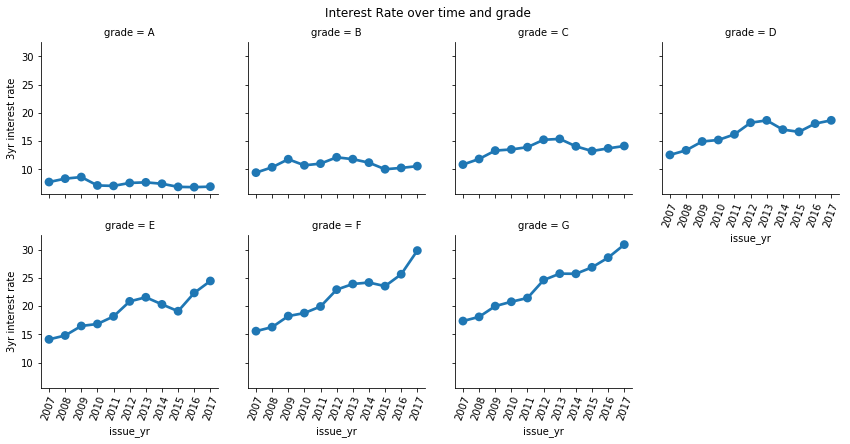

In [12]:
g = sns.FacetGrid(rate, col = 'grade', col_wrap = 4)
g = g.map(sns.pointplot, "issue_yr", "int_rate")
labels = np.arange(2007, 2018, 1)
labels = [str(i) for i in labels]
g = g.set_xticklabels(labels, rotation=70)
g = g.set_ylabels("3yr interest rate")

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Interest Rate over time and grade')


We can see that interest rate for grade D, E, F, G increase quickly from 2014. 

We have very few data points from 2007 to 2014. Let's take a closer look to see if this increase in average rate is not due to the small number of observations.


In [10]:
# Number of observations for each grade
# to verify the variance of rates
rate_count = pd.pivot_table(accepted[accepted['term'] == '36'],index=["grade","issue_yr"],values=["int_rate"], aggfunc='count')
rate_count = rate_count.unstack('grade')
rate_count

int_rate                                       
grade           A       B      C      D     E     F    G
issue_yr                                                
2007.0         78      98    141     99   100    52   35
2008.0        318     594    580    419   285   111   86
2009.0       1203    1445   1348    817   308   105   55
2010.0       2567    2805   2070   1253   336    91   34
2011.0       5579    4722   2203   1261   272    54   10
2012.0      10753   16805   9902   5088   795   103   24
2013.0      17057   40313  24693  14505  3231   608   15
2014.0      35333   53460  44042  20510  7066  1980  179
2015.0      70132   91783  77457  32740  9450  1363  248
2016.0      66862  114783  92317  36707  9932  2364  530
2017.0      52191   81609  69093  24905  7884  1386  674

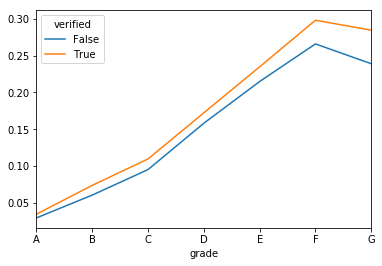

In [14]:
accepted['verified'] = accepted['verification_status'] == 'Verified'
grade_yr_loanamnt = pd.pivot_table(accepted,index=["grade","verified"],values=['funded_amnt'], aggfunc=np.sum)

grade_yr_loanamnt_default = pd.pivot_table(accepted[(accepted.loan_status == 'Charged Off') | (accepted.loan_status == 'Default')],index=["grade","verified"],values=['funded_amnt'], aggfunc=np.sum)
grade_yr_loanamnt_default.columns = ['Charged_off']
loan_verified = pd.merge(grade_yr_loanamnt, grade_yr_loanamnt_default, left_index = True, right_index = True)

loan_verified['chargeoff_rate']  = loan_verified['Charged_off'] /  loan_verified['funded_amnt'] 

loan_verified_unstack = loan_verified.unstack("verified")
verified_chargedoff = loan_verified_unstack['chargeoff_rate']
verified_chargedoff.plot()


The graph above shows the charge-off (default) rate for loans of different grade from 2008 to 2017. The yellow line is for loans whether the borrower's income has been verified. According to the graph, if the borrowers' income have been verified, itis more likely that the borrowers will default. This is counter-intuitive.

In [40]:
accepted2017 = accepted[accepted['issue_yr'] == 2017].dropna()
incomeVerified = accepted2017[accepted2017['verification_status'] != 'Not Verified']
incomeVerified = incomeVerified[['grade','annual_inc']]

quantile_low = incomeVerified['annual_inc'].min()
quantile_high = incomeVerified['annual_inc'].quantile(0.95)
filtered = incomeVerified[(incomeVerified['annual_inc'] > quantile_low) & (incomeVerified['annual_inc'] <= quantile_high)]

In [ ]:
grade_list = filtered['grade'].unique()
plt.figure(figsize=(10,10))
for i in range(len(grade_list)):
    data = filtered[filtered['grade'] == grade_list[i]]['annual_inc'].values
    sns.distplot(data, bins = 30)

plt.ylim(ymax = 0.00002)


In [44]:
# Median of incomes in each grade
income_median = pd.pivot_table(filtered, values = 'annual_inc', index = 'grade', aggfunc = np.median)
income_median

,annual_inc
grade,
A,80000.0
B,67000.0
C,65000.0
D,62000.0
E,61000.0
F,65000.0
G,67000.0
